# Starter cell 
## Run this cell first to enable working with this notebook

In [1]:
# Starter cell: make repo root importable, then run bootstrap
import sys
from pathlib import Path

# If running a notebook inside scripts/, cwd is .../perch-scale-bird-weights/scripts
# -> parent() is the repo root. If your notebooks are deeper, bump parents[2], etc.
ROOT = Path.cwd()
for _ in range(5):       # walk up to 5 levels until we find the repo
    if (ROOT / ".git").exists() or (ROOT / "README.md").exists():
        break
    ROOT = ROOT.parent

if str(ROOT) not in sys.path:
    sys.path.insert(0, str(ROOT))

# Supporting Information Figures S1-S5:

## Figure S1 - stacked bar plot of weight distribution per bird

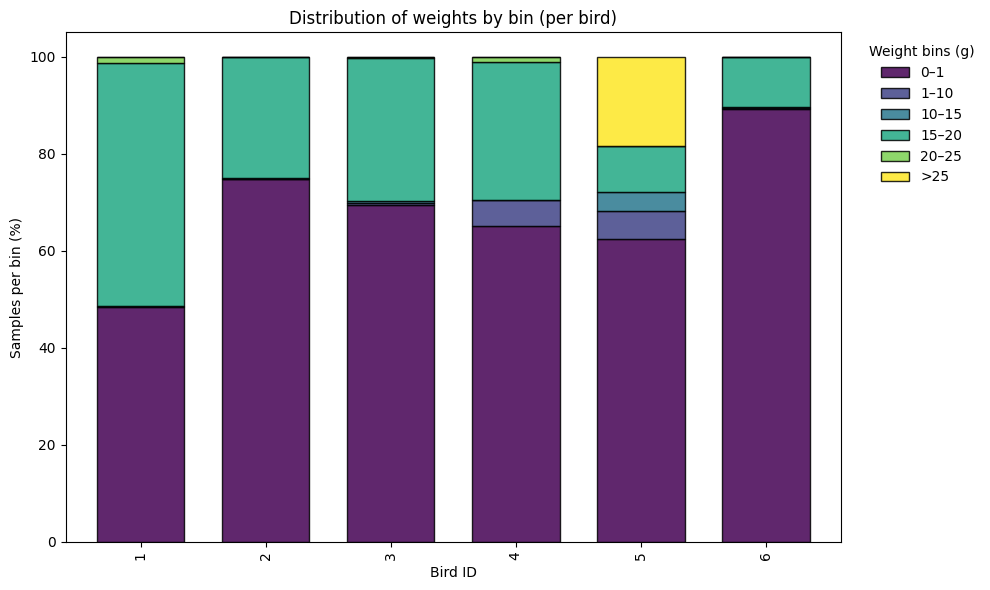

In [2]:
# Figure SI 1 — Stacked bar of per-bird weight distribution across bins (refactored)

from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scripts import _paths as P
from scripts.helpers import read_timeseries, find_bird_file

# ---------------- User parameters ----------------
# Canonical bird IDs to include (strings or ints). Example:
bird_ids = ['1', '2', '3', '4', '5', '6']   # <- adjust as needed

# Weight filtering (apply if you want to exclude outliers/artifacts)
low_thrd  = 0      # keep if aligned with your global defaults
high_thrd = 10000     # adjust if you want wider range for this SI figure

# Binning strategy:
# Example bins: [0–1], (1–10], (10–15], (15–20], (20–25], (>25)
bin_edges = [0, 1, 10, 15, 20, 25]
# --------------------------------------------------

# Build bin labels + include an overflow bin (> last edge)
bin_labels = [f"{bin_edges[i]}–{bin_edges[i+1]}" for i in range(len(bin_edges)-1)] + [f">{bin_edges[-1]}"]

all_bin_counts = []
kept_ids = []

for bid in bird_ids:
    try:
        # Find the correct CSV (handles .csv and .csv.gz under data/birds/)
        csv_path = find_bird_file(bid, birds_dir=P.BIRDS)

        # Read and filter (standardizes 'weight', ensures numeric, applies thresholds)
        df = read_timeseries(
            file_path=csv_path,
            low_thrd=low_thrd,
            high_thrd=high_thrd,
            keep_out_of_range=False,   # drop out-of-range rows
        )
        if df.empty:
            print(f"(info) No rows after filtering for bird_id={bid}; skipping.")
            continue

        weights = df['weight'].to_numpy()

        # Histogram with overflow bin by appending +inf
        counts, _ = np.histogram(weights, bins=np.append(bin_edges, np.inf))
        all_bin_counts.append(counts)
        kept_ids.append(str(bid))

    except FileNotFoundError as e:
        print(f"(warn) {e}")
    except Exception as e:
        print(f"(warn) Failed processing bird_id={bid}: {e}")

# Assemble table: rows = birds, cols = bins
if not all_bin_counts:
    raise SystemExit("No data accumulated for SI 1 plot. Check bird_ids or filters.")

bin_counts_df = pd.DataFrame(all_bin_counts, columns=bin_labels, index=kept_ids)

# Convert to per-bird percentage (stacked bars sum to 100% per bird)
percentage_counts_per_bird = bin_counts_df.div(bin_counts_df.sum(axis=1), axis=0) * 100

# --- Plot ---
plt.figure(figsize=(10, 6))
ax = percentage_counts_per_bird.plot(
    kind='bar',
    stacked=True,
    colormap='viridis',
    edgecolor='black',
    alpha=0.85,
    width=0.7,
    ax=plt.gca()
)

ax.set_xlabel('Bird ID')
ax.set_ylabel('Samples per bin (%)')
ax.set_title('Distribution of weights by bin (per bird)')
ax.legend(title='Weight bins (g)', bbox_to_anchor=(1.02, 1), loc='upper left', frameon=False)
plt.tight_layout()

# Optional save
# out_path = P.FIGS / "SI1_weight_bins_stacked.svg"
# out_path.parent.mkdir(parents=True, exist_ok=True)
# plt.savefig(out_path, bbox_inches='tight', dpi=300, format='svg')

plt.show()


## Figure S2 - 

### Code cell for this figure is in 'generate_fig_4.ipynb'

## Figure S3 - 

### For this figure run code cell for Panels A+B in 'generate_figure_5.ipynb' with bird 't1'

## FIgure S4 - 

### for Panels A-E run code cell for Panels A+B in 'generate_figure_5.ipynb' for bird ID's 2, 3, 4 and 6

### For Panels F+G run the next code cell for bird ID '5'

OOC range for bird 5: max=2822.72, min=30.13, mean=2702.48, median=2822.72


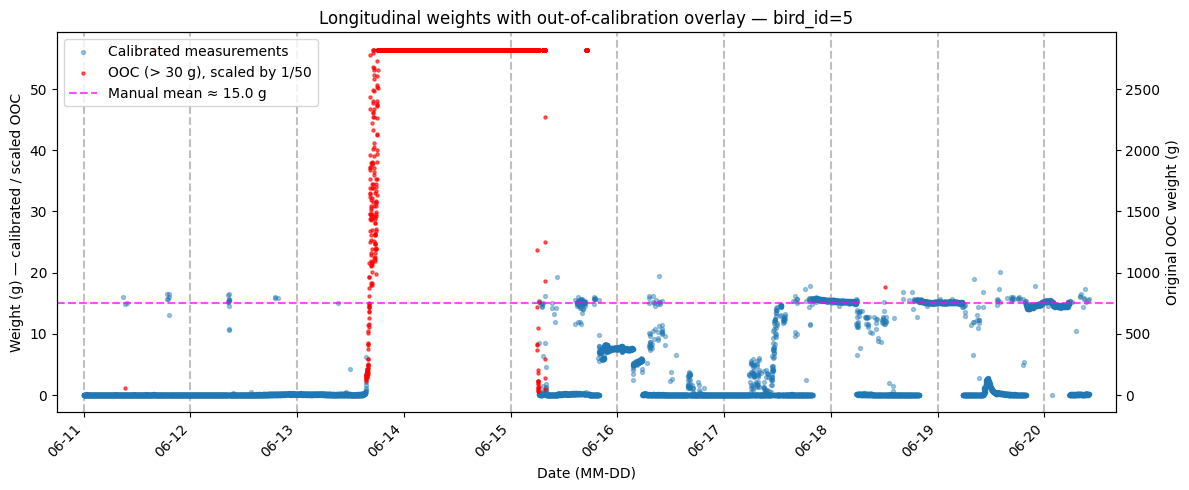

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import FuncFormatter
from pathlib import Path

from scripts import _paths as P
from scripts.helpers import read_timeseries, find_bird_file

def plot_longitudinal_ooc_panel(
    bird_id,
    start_date=None,
    end_date=None,
    start_time=None,
    end_time=None,
    low_thrd=0,
    high_thrd=30,
    ooc_scale=50,          # scale factor used to compress OOC values onto same y-range
    downsample=1,
    figsize=(14, 6),
    apply_ylim=True,
    ax=None,
):
    """
    Plot longitudinal weight data with two streams:
      - Calibrated (in-range) weights as blue points (primary y-axis, grams)
      - Out-of-calibration (OOC; > high_thrd) weights as red points, rescaled by `ooc_scale`
        to fit the same visual range. A secondary y-axis shows the original (unscaled) grams.

    Parameters
    ----------
    bird_id : str|int
        Canonical bird identifier.
    start_date, end_date, start_time, end_time : str|None
        Optional filters; dates are inclusive; times compare on clock time.
    low_thrd, high_thrd : float
        Calibrated range thresholds (grams).
    ooc_scale : float
        Divide OOC weights by this factor for plotting on the primary axis.
    downsample : int
        Plot every Nth sample (>=1).
    figsize : tuple
        Figure size.
    apply_ylim : bool
        If True, set y-limits around calibrated mean; else auto by data.
    ax : matplotlib.axes.Axes|None
        If provided, draw on this axis; else create a new figure.

    Returns
    -------
    fig, ax, ax2
    """
    # Resolve data file from new structure
    csv_path = find_bird_file(bird_id, birds_dir=P.BIRDS)

    # Calibrated data (keep only in-range)
    df_cal = read_timeseries(
        file_path=csv_path,
        low_thrd=low_thrd,
        high_thrd=high_thrd,
        start_date=start_date,
        end_date=end_date,
        start_time=start_time,
        end_time=end_time,
        keep_out_of_range=False,
    )

    # Out-of-calibration data (keep only > high_thrd)
    df_ooc = read_timeseries(
        file_path=csv_path,
        low_thrd=high_thrd,
        high_thrd=np.inf,
        start_date=start_date,
        end_date=end_date,
        start_time=start_time,
        end_time=end_time,
        keep_out_of_range=False,
    )

    if df_cal.empty and df_ooc.empty:
        print(f"No data found for bird_id={bird_id} in the requested interval.")
        return None, None, None

    # Stats on OOC slice (optional)
    if not df_ooc.empty:
        hi_max, hi_min = df_ooc['weight'].max(), df_ooc['weight'].min()
        hi_mean, hi_med = df_ooc['weight'].mean(), df_ooc['weight'].median()
        print(f"OOC range for bird {bird_id}: max={hi_max:.2f}, min={hi_min:.2f}, "
              f"mean={hi_mean:.2f}, median={hi_med:.2f}")

    # Downsample
    ds = max(1, int(downsample))
    if not df_cal.empty:
        df_cal = df_cal.iloc[::ds].dropna(subset=['weight'])
    if not df_ooc.empty:
        df_ooc = df_ooc.iloc[::ds].dropna(subset=['weight']).copy()
        df_ooc['weight_scaled'] = df_ooc['weight'] / ooc_scale

    # --- manual mean from metadata (preferred reference line) ---
    manual_mean = np.nan
    try:
        wdf = pd.read_csv(P.META / "daily_manual_weights.csv")
        if 'bird_id' in wdf.columns and 'mean' in wdf.columns:
            wdf['bird_id'] = wdf['bird_id'].astype(str).str.strip()
            row = wdf.loc[wdf['bird_id'] == str(bird_id)]
            if not row.empty:
                manual_mean = pd.to_numeric(row['mean'].iloc[0], errors='coerce')
    except Exception as e:
        print(f"(info) Could not read manual mean for bird_id={bird_id}: {e}")

    # Fallback if manual mean missing
    if np.isnan(manual_mean) and not df_cal.empty:
        manual_mean = float(df_cal['weight'].mean())

    # Prepare axes
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    else:
        fig = ax.figure

    # Plot calibrated stream
    if not df_cal.empty:
        ax.scatter(df_cal['Time'], df_cal['weight'],
                   alpha=0.4, color='tab:blue', s=8, label='Calibrated measurements')


    # Plot OOC stream (scaled on primary axis)
    if not df_ooc.empty:
        ax.scatter(df_ooc['Time'], df_ooc['weight_scaled'],
                   alpha=0.6, color='red', s=5,
                   label=f'OOC (> {high_thrd} g), scaled by 1/{ooc_scale}')
        
    # Manual mean line (from metadata if available)
    if not np.isnan(manual_mean):
        ax.axhline(manual_mean, color='magenta', linestyle='--', alpha=0.7,
                   label=f'Manual mean ≈ {manual_mean:.1f} g')
        
    # Day markers at midnights
    # Use calibrated stream if available else OOC stream for day boundaries
    df_ref = df_cal if not df_cal.empty else df_ooc
    if not df_ref.empty:
        day_starts = np.unique(df_ref['Time'].dt.normalize().to_numpy())
        for ds_ in day_starts:
            ax.axvline(ds_, color='black', linestyle='--', alpha=0.25, zorder=0)

    # Time axis formatting
    ax.xaxis.set_major_locator(mdates.DayLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
    fig.autofmt_xdate(rotation=45, ha='right')

    # X limits padding
    if not df_ref.empty:
        tmin, tmax = df_ref['Time'].min(), df_ref['Time'].max()
        ax.set_xlim(tmin - pd.Timedelta(hours=6), tmax + pd.Timedelta(hours=6))

    # Y limits
    if apply_ylim and (manual_mean is not None):
        ax.set_ylim(manual_mean * 0.75, manual_mean * 1.25)
    else:
        # Auto by data (consider both calibrated and scaled OOC)
        ymin = np.inf
        ymax = -np.inf
        if not df_cal.empty:
            ymin = min(ymin, df_cal['weight'].min())
            ymax = max(ymax, df_cal['weight'].max())
        if not df_ooc.empty:
            ymin = min(ymin, df_ooc['weight_scaled'].min())
            ymax = max(ymax, df_ooc['weight_scaled'].max())
        if np.isfinite(ymin) and np.isfinite(ymax):
            pad = 0.05 * (ymax - ymin if ymax > ymin else 1.0)
            ax.set_ylim(ymin - pad, ymax + pad)

    ax.set_xlabel('Date (MM-DD)')
    ax.set_ylabel('Weight (g) — calibrated / scaled OOC')
    ax.set_title(f'Longitudinal weights with out-of-calibration overlay — bird_id={bird_id}')
    ax.legend(loc='upper left')

    # Secondary y-axis: show ORIGINAL OOC grams via a formatter
    ax2 = ax.twinx()
    ax2.set_ylabel('Original OOC weight (g)')

    def inv_scale_formatter(y, _pos):
        # y on primary axis corresponds to y * ooc_scale in original grams
        return f"{int(round(y * ooc_scale))}"

    ax2.yaxis.set_major_formatter(FuncFormatter(inv_scale_formatter))
    ax2.set_ylim(ax.get_ylim())  # share limits; formatter takes care of scaling labels

    plt.tight_layout()
    return fig, ax, ax2

# --- Example usage (matches new structure) ---
bird_id = '5'
fig, ax, ax2 = plot_longitudinal_ooc_panel(
    bird_id=bird_id,
    start_date='2025-06-11',
    end_date=None,
    low_thrd=0,
    high_thrd=30,
    ooc_scale=50,
    downsample=40,
    figsize=(12, 5),
    apply_ylim=False,
)


# Figure S5 - overall summary comparison

## Panel A - Daily weight estimates (perch-scale) vs. manually measured true weights

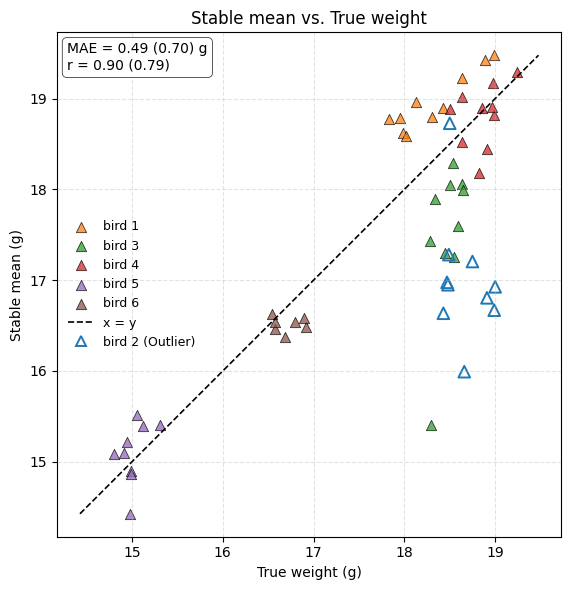

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

import seaborn as sns

def plot_estimate_vs_true_S5(
    df: pd.DataFrame,
    estimator: str = "stable_mean",   # or "mode_estimate"
    filtered_bird: str = "2",         # bird shown unfilled; filtered for primary metrics
    title: str | None = None,
    figsize=(8, 6),
):
    """
    SI Figure S5: Estimated vs. True weight scatter.

    df columns required: ['true_weight', 'stable_mean', 'mode_estimate', 'bird_id']
    - Plots all birds; bird_id==filtered_bird is rendered unfilled.
    - MAE and Pearson r are annotated as: filtered (no filtered_bird) first, then (all birds).

    Returns
    -------
    fig, ax
    """
    # --- basic checks ---
    needed = {"true_weight", "bird_id", estimator}
    missing = needed - set(df.columns)
    if missing:
        raise ValueError(f"DataFrame is missing required columns: {missing}")

    # --- build the two datasets for metrics ---
    df_all = df.dropna(subset=["true_weight", estimator, "bird_id"]).copy()
    df_flt = df_all[df_all["bird_id"].astype(str) != str(filtered_bird)].copy()

    # --- metrics helpers ---
    def _mae(y_true, y_pred):
        y_true = np.asarray(y_true, float)
        y_pred = np.asarray(y_pred, float)
        return float(np.mean(np.abs(y_pred - y_true))) if len(y_true) else np.nan

    def _pearson_r(y_true, y_pred):
        y_true = np.asarray(y_true, float)
        y_pred = np.asarray(y_pred, float)
        if len(y_true) < 2:
            return np.nan
        # guard against constant arrays
        if np.allclose(y_true, y_true[0]) or np.allclose(y_pred, y_pred[0]):
            return np.nan
        return float(np.corrcoef(y_true, y_pred)[0, 1])

    # filtered (primary) then unfiltered (in parentheses)
    mae_f = _mae(df_flt["true_weight"], df_flt[estimator])
    r_f   = _pearson_r(df_flt["true_weight"], df_flt[estimator])

    mae_a = _mae(df_all["true_weight"], df_all[estimator])
    r_a   = _pearson_r(df_all["true_weight"], df_all[estimator])

    # --- plot setup ---
    fig, ax = plt.subplots(figsize=figsize)

    # consistent palette by bird_id
    # Ensure bird_id values are clean ints/strings for consistent labels and ordering
    df_all["bird_id"] = df_all["bird_id"].apply(lambda x: str(int(x)) if pd.notna(x) else x)
    df_flt["bird_id"] = df_flt["bird_id"].apply(lambda x: str(int(x)) if pd.notna(x) else x)

    birds = sorted(df_all["bird_id"].unique(), key=lambda x: (x != filtered_bird, x))
    palette = sns.color_palette("tab10", n_colors=len(birds))
    color_map = dict(zip(birds, palette))

    # plot all birds except filtered_bird (filled markers)
    for bid in birds:
        sub = df_all[df_all["bird_id"].astype(str) == bid]
        if bid == str(filtered_bird):
            continue
        ax.scatter(
            sub["true_weight"], sub[estimator],
            s=55, marker="^", alpha=0.75,
            edgecolors="black", linewidths=0.6,
            c=[color_map[bid]], label=f"bird {bid}"
        )

    # overlay filtered_bird as unfilled (outline only)
    if str(filtered_bird) in birds:
        sub2 = df_all[df_all["bird_id"].astype(str) == str(filtered_bird)]
        ax.scatter(
            sub2["true_weight"], sub2[estimator],
            s=70, marker="^", alpha=1.0,
            facecolors="none", edgecolors=color_map[str(filtered_bird)],
            linewidths=1.4, label=f"bird {filtered_bird} (outline)"
        )

    # identity line
    x_min = min(df_all["true_weight"].min(), df_all[estimator].min())
    x_max = max(df_all["true_weight"].max(), df_all[estimator].max())
    ax.plot([x_min, x_max], [x_min, x_max], "k--", lw=1.2, label="x = y")

    # equal aspect & synchronized limits around the data range
    pad = 0.05 * (x_max - x_min if x_max > x_min else 1.0)
    lo, hi = x_min - pad, x_max + pad
    ax.set_xlim(lo, hi)
    ax.set_ylim(lo, hi)
    ax.set_aspect("equal", adjustable="box")

    # annotation: filtered first, then (all) in parentheses
    ann = (
        f"MAE = {mae_f:.2f} ({mae_a:.2f}) g\n"
        f"r = {r_f:.2f} ({r_a:.2f})"
    )
    ax.text(
        0.02, 0.98, ann, transform=ax.transAxes,
        va="top", ha="left",
        bbox=dict(boxstyle="round,pad=0.35", facecolor="white", alpha=0.9, linewidth=0.5)
    )

    # labels & title
    pretty = estimator.replace("_", " ").capitalize()
    ax.set_xlabel("True weight (g)")
    ax.set_ylabel(f"{pretty} (g)")
    if title is None:
        ax.set_title(f"{pretty} vs. True weight")
    else:
        ax.set_title(title)

    # legend: show each bird; ensure an unfilled-handle for bird 2 appears correctly
    # (we've already plotted it; but to ensure clear legend, we can build handles)
    handles, labels = ax.get_legend_handles_labels()

    # Optional: make a clearer handle for the outline bird
    if str(filtered_bird) in birds:
        outline_handle = Line2D(
            [], [], marker="^", linestyle="None",
            markerfacecolor="none", markeredgecolor=color_map[str(filtered_bird)],
            markeredgewidth=1.4, markersize=7, label=f"bird {filtered_bird} (outline)"
        )
        # Replace any existing label for that bird with the custom one
        # Remove previous entries with that label:
        filt = [l != f"bird {filtered_bird} (outline)" for l in labels]
        handles = [h for h, keep in zip(handles, filt) if keep]
        labels  = [l for l, keep in zip(labels,  filt) if keep]
        handles.append(outline_handle)
        labels.append(f"bird {filtered_bird} (Outlier)")

    ax.legend(
        handles, labels, loc="best",
        frameon=False, fontsize=9
    )

    ax.grid(True, linestyle="--", alpha=0.35)
    plt.tight_layout()
    return fig, ax


# Read summary_df 
summary_df = pd.read_csv(P.META / "all_birds_summary.csv")
fig, ax = plot_estimate_vs_true_S5(summary_df, estimator="stable_mean")  # or "mode_estimate"

## Panel B - Normalized stable estimates vs. true weights. 

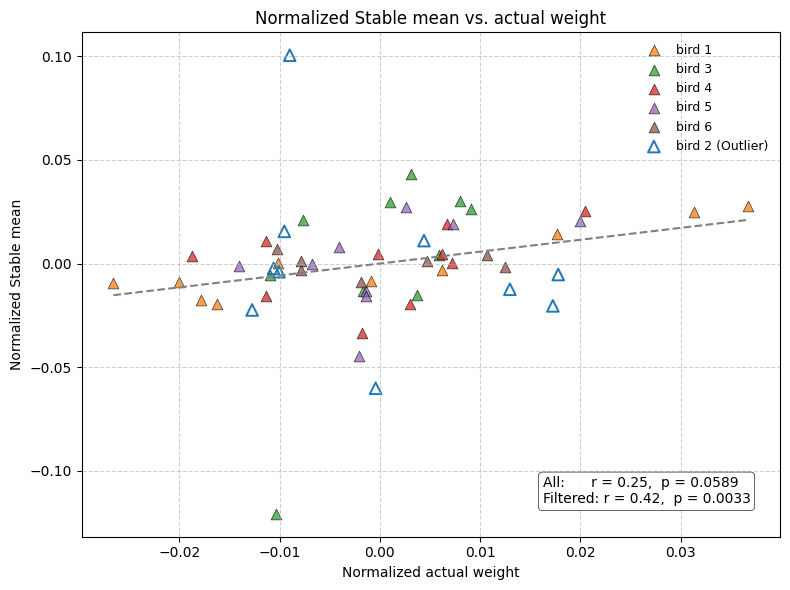

(<Figure size 800x600 with 1 Axes>,
 <Axes: title={'center': 'Normalized Stable mean vs. actual weight'}, xlabel='Normalized actual weight', ylabel='Normalized Stable mean'>)

In [5]:
# Panel B — Normalized estimated vs. normalized actual weights (with regression line and unfilled bird 2)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
from matplotlib.lines import Line2D

from scripts import _paths as P


def plot_normalized_weights(
    df: pd.DataFrame,
    estimator: str = "stable_mean",   # or "mode_estimate"
    marker: str = "^",
    filtered_bird: str = "2",         # bird shown as unfilled outline
    color_by_bird: bool = True,
    save_fig: bool = False,
    figsize=(8, 6),
    title: str | None = None,
):
    """
    Panel B (SI Figure S5): Normalized estimated vs. normalized actual weights.

    - Each bird's data are normalized by its mean.
    - Bird with ID `filtered_bird` is plotted as an unfilled marker (outline only).
    - Regression line always shown.
    - Annotation includes Pearson r and p-value for:
        • All points
        • Filtered (excluding `filtered_bird`)
    """
    required = {"true_weight", estimator, "bird_id"}
    missing = required - set(df.columns)
    if missing:
        raise ValueError(f"DataFrame missing required columns: {missing}")

    # Prepare normalized data
    df_norm = df.dropna(subset=["true_weight", estimator, "bird_id"]).copy()
    df_norm["bird_id"] = df_norm["bird_id"].apply(lambda x: str(int(x)) if pd.notna(x) else x)

    for bid, idx in df_norm.groupby("bird_id").groups.items():
        true_mean = df_norm.loc[idx, "true_weight"].mean()
        est_mean  = df_norm.loc[idx, estimator].mean()

        df_norm.loc[idx, "true_weight_norm"] = (
            (df_norm.loc[idx, "true_weight"] - true_mean) / true_mean
            if (true_mean != 0 and not np.isnan(true_mean)) else np.nan
        )
        df_norm.loc[idx, "estimate_norm"] = (
            (df_norm.loc[idx, estimator] - est_mean) / est_mean
            if (est_mean != 0 and not np.isnan(est_mean)) else np.nan
        )

    df_norm = df_norm.dropna(subset=["true_weight_norm", "estimate_norm"])

    # --- Correlations ---
    def safe_pearson(x, y):
        if len(x) >= 2 and pd.Series(x).nunique() > 1 and pd.Series(y).nunique() > 1:
            r, p = pearsonr(x, y)
            return float(r), float(p)
        return np.nan, np.nan

    # All points
    r_all, p_all = safe_pearson(df_norm["true_weight_norm"], df_norm["estimate_norm"])

    # Filtered (exclude the outline bird)
    df_norm_flt = df_norm[df_norm["bird_id"] != str(filtered_bird)]
    r_flt, p_flt = safe_pearson(df_norm_flt["true_weight_norm"], df_norm_flt["estimate_norm"])

    # ---- Plot ----
    fig, ax = plt.subplots(figsize=figsize)

    birds = sorted(df_norm["bird_id"].unique(), key=lambda x: (x != filtered_bird, x))
    palette = sns.color_palette("tab10", n_colors=len(birds))
    color_map = dict(zip(birds, palette))

    # Plot all filled birds
    for bid in birds:
        if bid == filtered_bird:
            continue
        sub = df_norm[df_norm["bird_id"] == bid]
        ax.scatter(
            sub["true_weight_norm"], sub["estimate_norm"],
            s=60, marker=marker, alpha=0.75,
            edgecolors="black", linewidths=0.5,
            c=[color_map[bid]], label=f"bird {bid}"
        )

    # Plot unfilled bird (filtered_bird)
    if filtered_bird in birds:
        sub2 = df_norm[df_norm["bird_id"] == filtered_bird]
        ax.scatter(
            sub2["true_weight_norm"], sub2["estimate_norm"],
            s=70, marker=marker, facecolors="none",
            edgecolors=color_map[filtered_bird],
            linewidths=1.4, label=f"bird {filtered_bird} (Outlier)"
        )

    # Regression line across all normalized points
    sns.regplot(
        data=df_norm,
        x="true_weight_norm", y="estimate_norm",
        scatter=False, ci=None, color="gray",
        line_kws={"linestyle": "--", "linewidth": 1.5}
    )

    # Annotation: show both All and Filtered
    def fmt_val(v, nd=2):
        return "n/a" if np.isnan(v) else f"{v:.{nd}f}"

    ann = (
        f"All:      r = {fmt_val(r_all)},  p = {fmt_val(p_all, 4)}\n"
        f"Filtered: r = {fmt_val(r_flt)},  p = {fmt_val(p_flt, 4)}"
    )
    ax.text(
        0.66, 0.06, ann, transform=ax.transAxes,
        va="bottom", ha="left",
        bbox=dict(boxstyle="round", facecolor="white", alpha=0.85, linewidth=0.5)
    )

    # Labels & layout
    pretty = estimator.replace("_", " ").capitalize()
    ax.set_xlabel("Normalized actual weight")
    ax.set_ylabel(f"Normalized {pretty}")
    ax.set_title(title or f"Normalized {pretty} vs. actual weight")

    ax.grid(True, linestyle="--", alpha=0.6)
    plt.tight_layout()

    # Legend with proper outline handle for filtered bird
    handles, labels = ax.get_legend_handles_labels()
    if filtered_bird in birds:
        outline_handle = Line2D(
            [], [], marker=marker, linestyle="None",
            markerfacecolor="none", markeredgecolor=color_map[filtered_bird],
            markeredgewidth=1.4, markersize=7, label=f"bird {filtered_bird} (outline)"
        )
    ax.legend(handles, labels, loc="best", frameon=False, fontsize=9)

    if save_fig:
        out = (P.FIGS / f"{estimator}_normalized_weights_color.svg")
        out.parent.mkdir(parents=True, exist_ok=True)
        print(out.absolute())
        plt.savefig(out, bbox_inches="tight", dpi=300, format="svg")

    plt.show()
    return fig, ax


# Example usage:
summary_df = pd.read_csv(P.META / "all_birds_summary.csv")
plot_normalized_weights(summary_df, estimator="stable_mean", color_by_bird=True)
